In [7]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [8]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [9]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [10]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [11]:
!pip install -q findspark

In [12]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
url = "https://cdac-project.s3.amazonaws.com/us_accident.csv"
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("us_accident.csv"), header=True, inferSchema= True)
df.show(5)

In [21]:
from pyspark.sql import SparkSession, functions,types
from timeit import default_timer as timer
from pyspark.sql.functions import expr
import sys, re, math, uuid, os


In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
# TOTAL ACCIDENT REPORTS(2016 - 2020)
total_states = df.groupBy('State').agg(functions.count(functions.lit(1)).alias('Total')).sort('Total',ascending=False)
print(total_states.show(10))
# total_states['State'] = total_states.index
total_states.write.csv('total_accident.csv')


In [ ]:
fig, ax = plt.subplots(figsize=(19.7,10.27))
sns.barplot(x = "State", y = "Total", data = total_states.toPandas())

In [79]:
#ACCIDENT BY SEVERITIES (LOW TO HIGH)
lth= df.groupBy('State','Severity').agg(functions.count(functions.lit(1)).alias('Total Severity')).sort('Severity',ascending=False)
print(lth.show(10))

# total_states.coalesce(1).write.csv(f'{output_path}/Graph{count}', header=True, mode='overwrite')
# lth.coalesce(1).write.csv('mycsv1.csv')

+-----+--------+--------------+
|State|Severity|Total Severity|
+-----+--------+--------------+
|   LA|       4|          1184|
|   NJ|       4|          4392|
|   CA|       4|          9135|
|   TN|       4|          2096|
|   NV|       4|           517|
|   UT|       4|          1352|
|   SD|       4|            44|
|   CO|       4|          4206|
|   MT|       4|           248|
|   RI|       4|           111|
+-----+--------+--------------+
only showing top 10 rows

None


In [ ]:
# ACCIDENT COUNT PER YEAR
year_df = df.select('State', (functions.year(functions.to_timestamp("Start_Time"))).alias('year')).groupBy(
        'year').agg(functions.count(functions.lit(1))).sort('year')
print(year_df.show(10))
fig, ax = plt.subplots(figsize=(19.7,10.27))
sns.lineplot(x = "year", y = "count(1)", data = year_df.toPandas())

In [ ]:
# ACCIDENT COUNT BY MONTH
month_df = df.select('State', (functions.month(functions.to_timestamp("Start_Time"))).alias('month')).groupBy(
        'month').agg((functions.count(functions.lit(1))).alias('total_accidents')).sort('month')
print(month_df.show(10))
fig, ax = plt.subplots(figsize=(19.7,10.27))
sns.lineplot(x = "month", y = "total_accidents", data = month_df.toPandas())

In [ ]:
# ACCIDENT COUNT BY DAY OF THE WEEK
weekday_df = df.select((functions.dayofweek(functions.to_timestamp("Start_Time"))).alias('week_day')).groupBy(
        'week_day').agg((functions.count(functions.lit(1))).alias('total_accidents')).sort('week_day')
print(weekday_df.show(10))
fig, ax = plt.subplots(figsize=(19.7,10.27))
sns.lineplot(x = "week_day", y = "total_accidents", data = weekday_df.toPandas())

In [ ]:
 # ACCIDENT COUNT BY HOUR
hour_df = df.select((functions.hour(functions.to_timestamp("Start_Time"))).alias('hour_df')).groupBy('hour_df')\
        .agg((functions.count(functions.lit(1))).alias('total_accidents')).sort('hour_df')
print(hour_df.show(50))
fig, ax = plt.subplots(figsize=(19.7,10.27))
sns.lineplot(x = "hour_df", y = "total_accidents", data = hour_df.toPandas())

+-----------------+-----------+--------+
|Weather_Condition|weather_acc|mon_year|
+-----------------+-----------+--------+
|             Fair|          7|1-1-2016|
|    Mostly Cloudy|         53|1-2-2016|
|         Overcast|        190|1-2-2016|
|           Cloudy|          2|1-2-2016|
|       Light Snow|         97|1-2-2016|
+-----------------+-----------+--------+
only showing top 5 rows

None


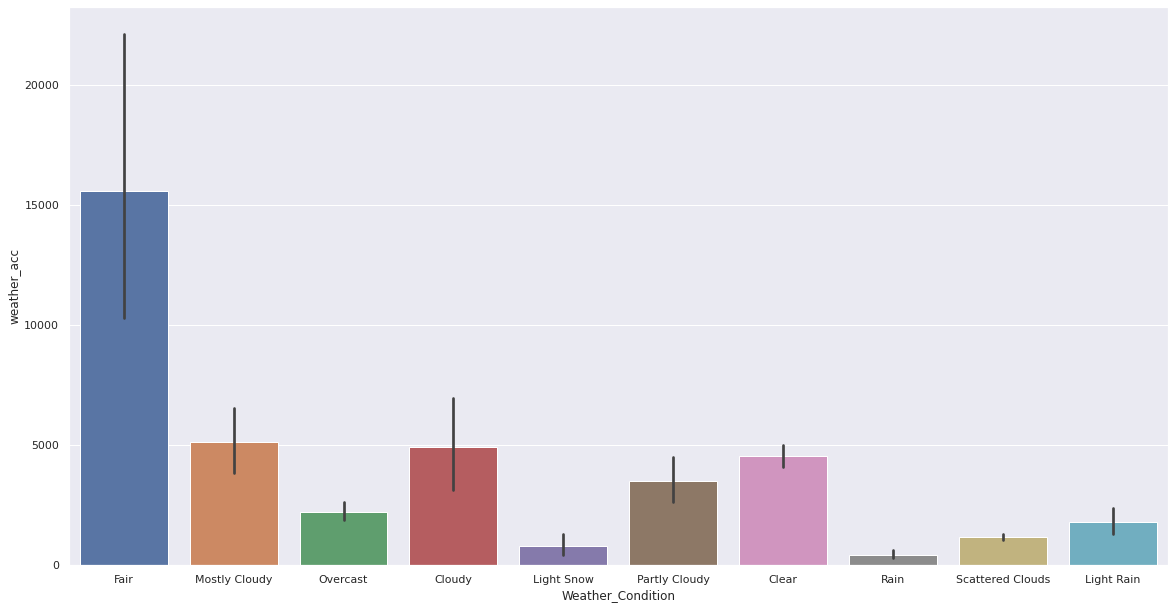

In [69]:
# ACCIDENTS DUE TO TOP 10 WEATHER CONDITIONS
weather_df = df.filter(df['Weather_Condition'].isNotNull())
#FINDING THE WEATHER CONDITION WHICH CAUSED HIGHEST NUMBER OF ACCIDENTS
weather_df = weather_df.groupBy('Weather_Condition').agg(functions.count(functions.lit(1)).alias('top_weather')).sort('top_weather',ascending=False)
# print(weather_df.show())
top_10_weather = df.where(expr("Weather_Condition = 'Fair' or Weather_Condition= 'Clear' or Weather_Condition= 'Mostly Cloudy' or Weather_Condition= 'Overcast'"
                                "or Weather_Condition= 'Partly Cloudy' or Weather_Condition= 'Cloudy' or Weather_Condition= 'Scattered Clouds' or Weather_Condition= 'Light Rain' "
                                "or Weather_Condition= 'Light Snow' or Weather_Condition= 'Rain'"))
#REFORMATTING THE DATE IN THIS FORMAT DAY/MONTH FOR PLOTTING PURPOSES
@functions.udf(returnType=types.StringType())
def date_reformat(month):
    month = f"1-{month}"
    return month
top_10_weather = top_10_weather.groupBy(functions.year(functions.to_timestamp("Start_Time")).alias('year'),
                                        functions.month(functions.to_timestamp("Start_Time")).alias('month'),'Weather_Condition')\
    .agg(functions.count(functions.lit(1)).alias('weather_acc')).sort('year','month')

top_10_weather = top_10_weather.withColumn('month', date_reformat(top_10_weather['month']))
top_10_weather=top_10_weather.select('Weather_Condition','weather_acc',functions.concat(functions.col('month'),functions.lit("-"),
                                                                                        functions.col('year')).alias('mon_year'))
print(top_10_weather.show(5))
fig, ax = plt.subplots(figsize=(19.7,10.27))
sns.barplot(x = "Weather_Condition", y = "weather_acc", data = top_10_weather.toPandas())

+-------+-----------+---------+
|  month|       City|total_acc|
+-------+-----------+---------+
|January|      Miami|     6245|
|January|    Houston|     2896|
|January|   Richmond|      699|
|January|     Dallas|     3040|
|January|San Antonio|      699|
|January|    Raleigh|     1288|
|January|     Austin|     1132|
|January|  Charlotte|     1884|
|January|  Nashville|     1085|
|January|   San Jose|     1221|
+-------+-----------+---------+
only showing top 10 rows

None


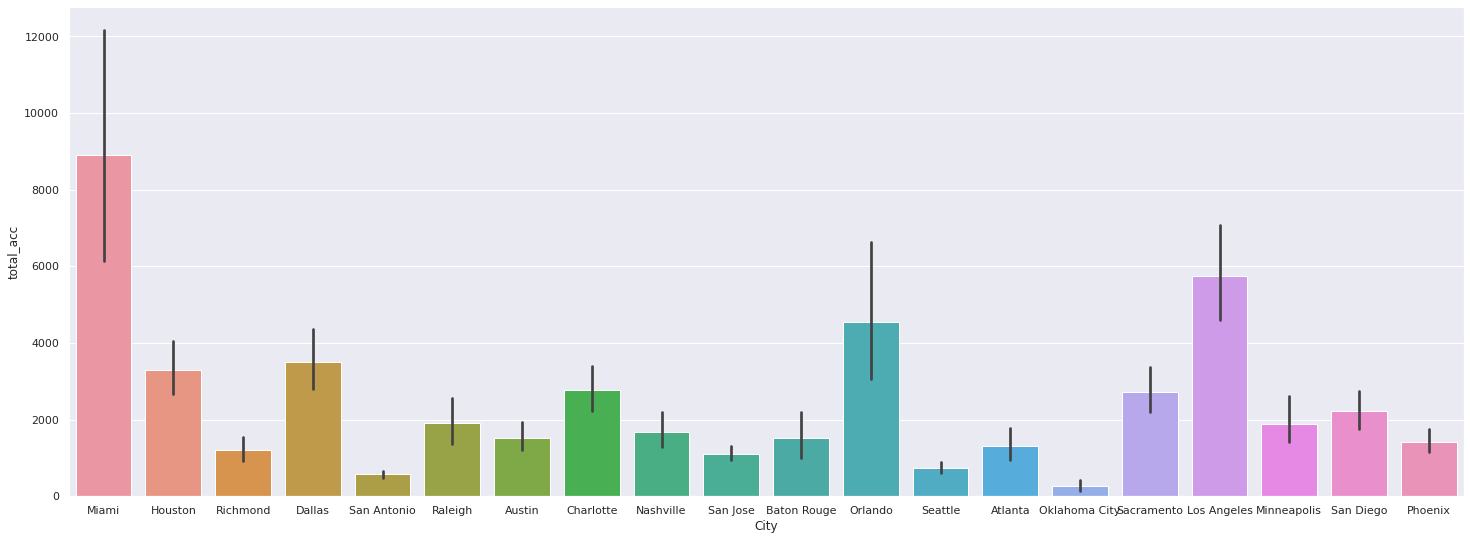

In [74]:
# AGGREGATED MONTHLY ACCIDENTS IN TOP TWENTY CITIES
import calendar
#GETTING NAME OF THE MONTH FROM THE MONTH NUMBER
@functions.udf(returnType=types.StringType())
def get_month_name(month):
    return calendar.month_name[month]

#FIND THE CITIES WITH HIGHEST NUMBER OF ACCIDENTS
top_20_cities = df.groupBy('City').agg(functions.count(functions.lit(1)).alias('Acccount')).sort('Acccount',
                                                                                                    ascending=False)
# print(top_20_cities.show())
top_20_cities = df.where(expr(
    "City = 'Houston' or City= 'Los Angeles' or City= 'Charlotte' or City= 'Dallas'"
    "or City= 'Austin' or City= 'Raleigh' or City= 'Atlanta' or City= 'Oklahoma City' "
    "or City= 'Miami' or City= 'Baton Rouge' or City = 'Nashville' or City= 'Sacramento' or City= 'Orlando' or City= 'Phoenix'"
    "or City= 'Minneapolis' or City= 'Seattle' or City= 'San Diego' or City= 'San Antonio' "
    "or City= 'Richmond' or City= 'San Jose' "))
top_20_cities = top_20_cities.groupBy(functions.month(functions.to_timestamp("Start_Time")).alias('month'), 'City') \
    .agg(functions.count(functions.lit(1)).alias('total_acc')).sort('month')
top_20_cities = top_20_cities.withColumn('month', get_month_name(top_20_cities['month']))
print(top_20_cities.show(10))

fig, ax = plt.subplots(figsize=(25,9))
sns.barplot(x = "City", y = "total_acc", data = top_20_cities.toPandas())

In [75]:
# LOW SEVERITY ACCIDENTS DUE TO LOW VISIBILITY
# HIGH SEVERITY ACCIDENTS DUE TO LOW VISIBILITY
visibility_df = df.filter(df['Visibility(mi)'].isNotNull()).where((df['Visibility(mi)']<=5.0) & ((df['Severity'] =="1") | (df['Severity']=="2")))
visibility_df= visibility_df.groupBy('State').agg(functions.count(functions.lit(1))
                                                                        .alias('Low Severity Accidents due to Low visibility')).sort('Low Severity Accidents due to Low visibility',ascending=False)
visibility_df=visibility_df.withColumnRenamed('State','States')
# print(visibility_df.show())
high_sev_lowviz = df.filter(df['Visibility(mi)'].isNotNull()).where((df['Visibility(mi)']<=5.0) & ((df['Severity'] =="3") | (df['Severity']=="4")))
high_sev_lowviz = high_sev_lowviz.groupBy('State').agg(functions.count(functions.lit(1))
                                                                        .alias('High Severity Accidents due to Low visibility')).sort('High Severity Accidents due to Low visibility',ascending=False).cache()
# print(high_sev_lowviz.show())

joined_df = visibility_df.join(functions.broadcast(high_sev_lowviz),[visibility_df['States']==high_sev_lowviz['State']])
joined_df= joined_df.drop('State')
print(joined_df.show(10))

+------+--------------------------------------------+---------------------------------------------+
|States|Low Severity Accidents due to Low visibility|High Severity Accidents due to Low visibility|
+------+--------------------------------------------+---------------------------------------------+
|    SC|                                        7671|                                          263|
|    AZ|                                         653|                                           82|
|    LA|                                        3353|                                          238|
|    MN|                                       18484|                                          568|
|    NJ|                                        5208|                                          926|
|    DC|                                         357|                                           48|
|    OR|                                       16210|                                          962|
